<a href="https://colab.research.google.com/github/sidms24/internship/blob/main/DGAE_sinosodial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from diffusers import UNet1DModel
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [2]:
class noisescheduler:
  def __init__(self, beta_start=0.01, beta_end=0.2, num_timesteps= 1000):
    self.beta_start = beta_start
    self.beta_end = beta_end
    self.num_timesteps = num_timesteps
    self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
    self.alphas = 1 - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
    self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
    self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)


  def add_noise(self, x, t):
    sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].unsqueeze(-1).unsqueeze(-1)
    sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(-1).unsqueeze(-1)


    noise = torch.randn_like(x)
    return sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise, noise



In [3]:
class Encoder(nn.Module):
  def __init__(self, din, latent_dim, base_channels):
    super().__init__()

    self.din = din
    self.latent_dim = latent_dim
    self.base_channels = base_channels


    self.block0 = nn.Sequential(
        nn.Conv1d(din, base_channels, kernel_size=4,stride = 2, padding=1),
        nn.BatchNorm1d(base_channels),
        nn.ReLU()
    )


    self.block1 = nn.Sequential(
        nn.Conv1d(base_channels, base_channels*2, kernel_size=4,stride = 2, padding=1),
        nn.BatchNorm1d(base_channels*2),
        nn.ReLU()
    )

    self.block2 = nn.Sequential(
        nn.Conv1d(base_channels*2, base_channels*4, kernel_size=4,stride = 2, padding=1),
        nn.BatchNorm1d(base_channels*4),
        nn.ReLU()
    )

    self.block3 = nn.Sequential(
        nn.Conv1d(base_channels*4, base_channels*4, kernel_size=4,stride = 2, padding=1),
        nn.BatchNorm1d(base_channels*4),
        nn.ReLU()
    )



    self.adaptive_pool = nn.AdaptiveAvgPool1d((4))

    self.fcmean = nn.Linear(base_channels*4*4 , latent_dim)
    self.fclogvar = nn.Linear(base_channels*4 * 4 , latent_dim)

  def reparametrization(self, mean, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mean + eps * std

  def forward(self, x):
    x = self.block0(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.adaptive_pool(x)
    x = x.reshape(x.shape[0], -1)
    mean = self.fcmean(x)
    logvar = self.fclogvar(x)
    sample = self.reparametrization(mean, logvar)
    return sample, mean, logvar

  def features(self, x):
    features = {}
    x = self.block0(x)
    features['block0'] = x
    x = self.block1(x)
    features['block1'] = x
    x = self.block2(x)
    features['block2'] = x
    x = self.block3(x)
    features['block3'] = x

    x = self.adaptive_pool(x)
    features['adaptive_pool'] = x
    x = x.reshape(x.shape[0], -1)
    mean = self.fcmean(x)
    logvar = self.fclogvar(x)
    features['Latent'] =  self.reparametrization(mean, logvar)
    features['mean'] = mean
    features['logvar'] = logvar
    return features


In [4]:
class Decoder(nn.Module):
    def __init__(self, din, latent_dim, base_channels, num_channels =1):
        super().__init__()
        self.din = din
        self.latent_dim = latent_dim
        self.base_channels = base_channels
        self.num_channels = num_channels

        self.latent_proj = nn.Linear(latent_dim, base_channels * 2)


        self.unet = UNet1DModel(
            sample_size=din,
            in_channels=num_channels + base_channels*2,
            out_channels=num_channels,
            layers_per_block=2,
            block_out_channels=(base_channels, base_channels * 2, base_channels * 4),
            down_block_types=("DownBlock1D", "DownBlock1D", "AttnDownBlock1D"),
            up_block_types=("AttnUpBlock1D", "UpBlock1D", "UpBlock1D"),
            mid_block_type="UNetMidBlock1D",
        )

    def forward(self, noisy_x, latent_z,t):
      latent_proj = self.latent_proj(latent_z)
      latent_proj = latent_proj.unsqueeze(-1).expand(-1, -1, noisy_x.shape[-1])

      x = torch.cat([noisy_x, latent_proj], dim=1)
      x = self.unet(x, t, return_dict=False)[0]
      return x

In [5]:
class DGAE(nn.Module):
  def __init__(self, din, latent_dim, base_channels):
    super().__init__()
    self.encoder = Encoder(din, latent_dim, base_channels)
    self.decoder = Decoder(din, latent_dim, base_channels)
    self.din =din

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x, latent_z, t):
    return self.decoder(x, latent_z, t)
  def forward(self, x, timestep = None):
    latent_sample, mean, logvar = self.encoder(x)

    if timestep is None:
      timestep = torch.zeros(x.shape[0], device=x.device, dtype=torch.long)

    noisy_x, noise = scheduler.add_noise(x, timestep)


    reconstruction = self.decoder(noisy_x, timestep, latent_sample)
    return reconstruction, latent_sample, mean, logvar


class DGAE_loss(nn.Module):
  def __init__(self):
    super().__init__()
    self.recon = nn.MSELoss()
    self.kl_loss = nn.KLDivLoss()

  def forward(self, x, x_hat, mean, logvar, kl_weight = 0.1, recon_weight = 0.2):
    recon_loss = self.recon(x, x_hat)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_weight * recon_loss +  kl_weight* kl_loss

In [6]:
def train(model, dataloader, optimizer, scheduler,  device, epoch, num_epochs, loss_fn= DGAE_loss):
  model.train()
  total_loss_epoch = 0
  bar = tqdm(dataloader, desc=f"Epoch {epoch+1} of {num_epochs}")

  for data in bar:
    batch_size = data[0].shape[0]
    x, label = data
    x = x.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    t = torch.randint(0, 1000, (x.shape[0],)).to(device)
    noisy_x, noise = scheduler.add_noise(x, t)
    latent_z, mean, logvar = model.encoder(noisy_x)
    x_hat = model.decoder(noisy_x, latent_z, t)
    loss = loss_fn(x, x_hat, mean, logvar)
    loss.backward()
    optimizer.step()
    total_loss_epoch += loss.item()
    bar.set_postfix(loss=f"{loss:.4f}")
  avg_loss = total_loss_epoch / len(dataloader)
  return avg_loss

In [7]:
n = 1000
tsteps = 2048
t = np.linspace(0, 2 * np.pi,tsteps)

X_sin = np.zeros((n, tsteps), dtype=np.float32)
y_sin = np.zeros((n, 3), dtype=np.float32)
X_cos = np.zeros((n, tsteps), dtype=np.float32)
y_cos = np.zeros((n, 3), dtype=np.float32)
X_comp = np.zeros((n, tsteps), dtype=np.float32)
y_comp = np.zeros((n, 3), dtype=np.float32)
for i in range(n):

    amplitude = np.random.uniform(1, 3)
    frequency = np.random.uniform(0.5,2)


    X_sin[i, :] = amplitude * np.sin(frequency  * t)
    y_sin[i, :] = [1, 0, 0]


    X_cos[i, :] = amplitude * np.cos(frequency *  t)
    y_cos[i, :] = [0, 1,0]


    X_comp[i, :] = amplitude * (np.sin(frequency * t) + np.cos(frequency *t))
    y_comp[i, :] = [0, 0, 1]

X = np.concatenate([X_sin, X_cos, X_comp], axis=0)
y = np.concatenate([y_sin, y_cos, y_comp], axis=0)

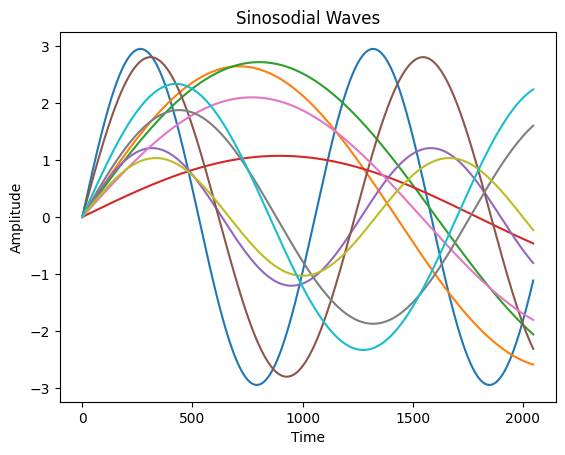

In [12]:
for i in range(10):
  plt.plot(X[i])
  plt.title("Sinosodial Waves")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
plt.show()


In [ ]:
X = X[:, np.newaxis, :]
dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
y.shape

(3000, 3)

In [ ]:
model = DGAE(din=1, latent_dim=2048, base_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = noisescheduler()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
loss_fn = DGAE_loss()

num_epochs = 10
model = DGAE(din=1, latent_dim=16, base_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = noisescheduler()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
loss_fn = DGAE_loss()

num_epochs = 10
for epoch in range(num_epochs):
    train(model, dataloader, optimizer, scheduler, device = device, epoch=epoch, num_epochs = num_epochs, loss_fn = loss_fn)

Epoch 1 of 10:   0%|          | 0/94 [00:00<?, ?it/s]


KeyboardInterrupt: 

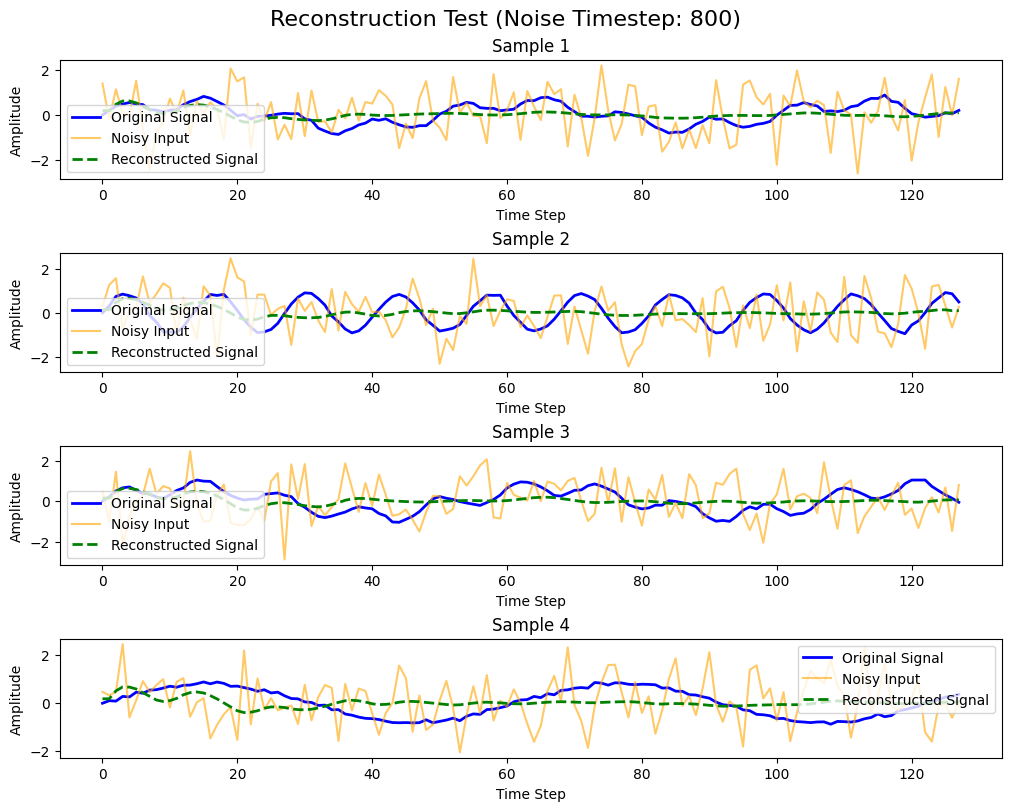

In [ ]:
x, _ = next(iter(dataloader))
x = x.to(device)
n = 4
originals = x[20:n+20]
t_val = 800

with torch.no_grad():

  t_val = 800
  t = torch.full((n,), t_val, device=device, dtype=torch.long)
  noisy_originals, noise = scheduler.add_noise(originals, t)
  latent_z, _, _ = model.encoder(noisy_originals)
  reconstructed_x = model.decoder(noisy_originals, latent_z, t)

originals = originals.cpu().numpy().squeeze()
noisy_originals = noisy_originals.cpu().numpy().squeeze()
reconstructed_x = reconstructed_x.cpu().numpy().squeeze()
fig, axes = plt.subplots(n, 1, figsize=(10, 8), constrained_layout=True)
fig.suptitle(f'Reconstruction Test (Noise Timestep: {t_val})', fontsize=16)
for i in range(n):
    axes[i].plot(originals[i], label='Original Signal', color='blue', linewidth=2)
    axes[i].plot(noisy_originals[i], label='Noisy Input', color='orange', alpha=0.6)
    axes[i].plot(reconstructed_x[i], label='Reconstructed Signal', color='green', linestyle='--', linewidth =2)
    axes[i].legend()
    axes[i].set_title(f'Sample {i+1}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Amplitude')

plt.show()



In [ ]:
all_features = []
all_labels = []
with torch.no_grad():
    for x, labels in dataloader:
        x = x.to(device)


        latent_vectors = model.encoder.features(x)["Latent"]

        all_features.append(latent_vectors)
        all_labels.append(labels)
all_features_np = [features.cpu().numpy() for features in all_features]

all_features = np.concatenate(all_features_np, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

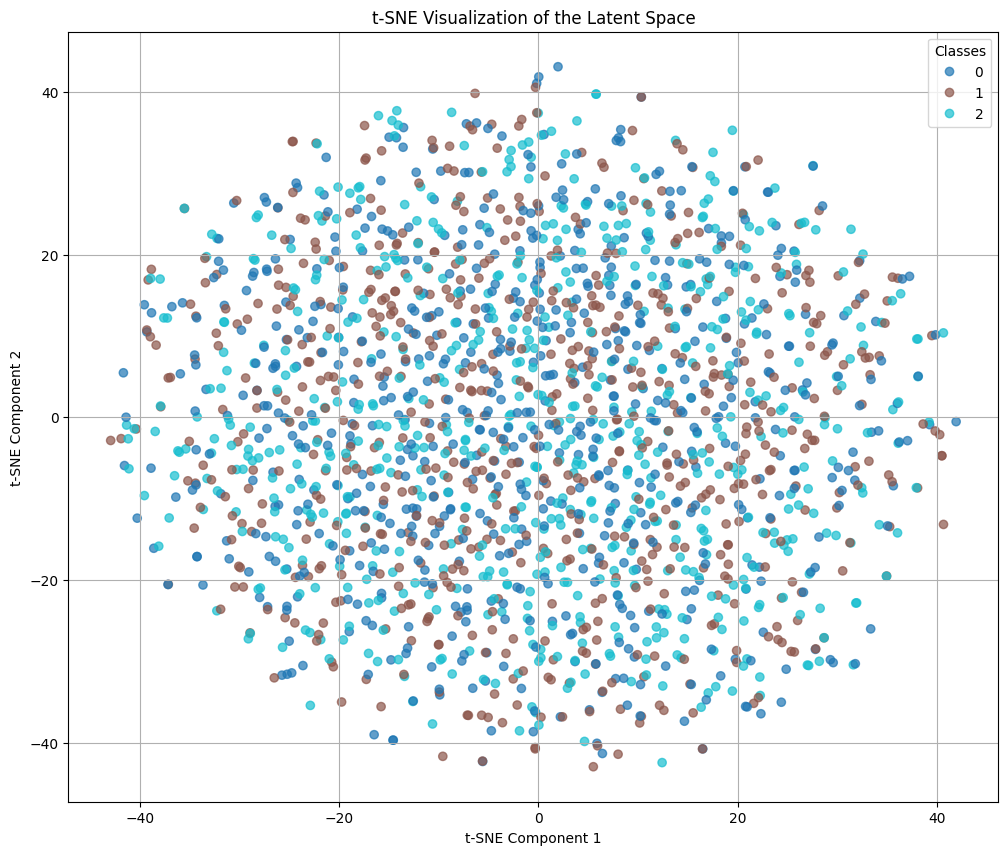

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_features = tsne.fit_transform(all_features)

# Plot the 2D features
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=all_labels, cmap='tab10', alpha=0.7)

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE Visualization of the Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

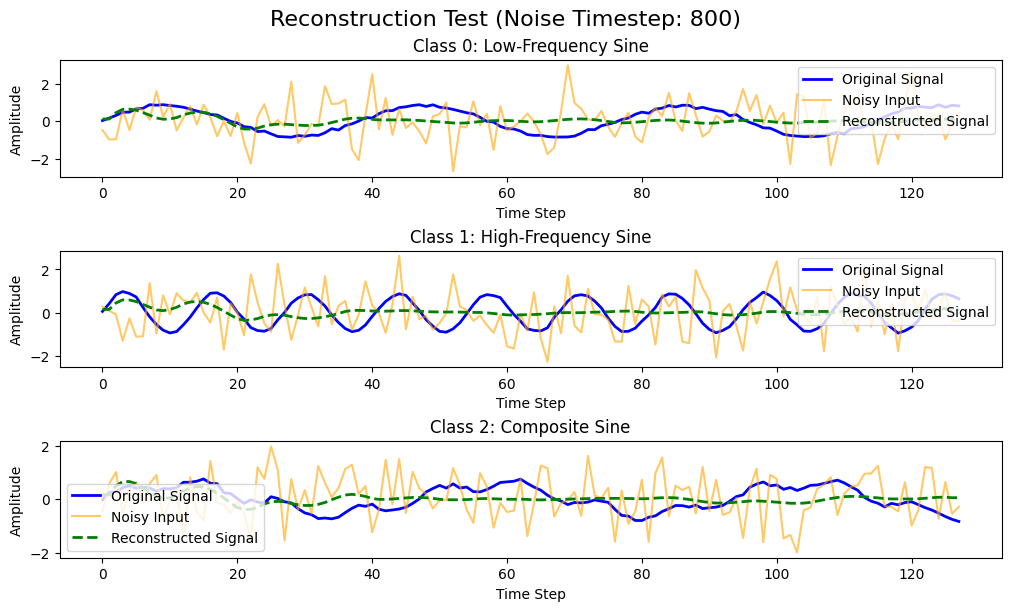

In [ ]:
n_classes = 3
originals_to_plot = [None] * n_classes
labels_to_plot = [None] * n_classes
found_classes_count = 0 # Use a separate counter to track how many *unique* classes we've found

# Iterate through the entire dataset to find one sample of each class
# Using the dataset directly ensures we see all samples, not just those in the first few batches
for i in range(len(dataset)):
    sample_x, sample_y = dataset[i]
    sample_y_item = sample_y.item() # Get the scalar value of the label tensor

    # If we haven't found a sample for this class yet, store it
    if originals_to_plot[sample_y_item] is None:
        originals_to_plot[sample_y_item] = sample_x
        labels_to_plot[sample_y_item] = sample_y_item # Store the integer label
        found_classes_count += 1

    # Break the loop once we have one of each class
    if found_classes_count == n_classes:
        break

# Check if we found a sample for every expected class
if found_classes_count < n_classes:
    print(f"Warning: Only found {found_classes_count} out of {n_classes} classes in the dataset.")
    # Optionally handle this case, e.g., by filtering out None values
    # For this example, we will assume all classes are present in the dataset
    # If not, you would need to filter originals_to_plot and labels_to_plot

# Stack the found samples into a single tensor, filtering out potential None values
# This is a safeguard in case the above loop didn't find all classes
valid_originals = [item for item in originals_to_plot if item is not None]

# Ensure we have valid samples to stack
if not valid_originals:
    raise ValueError("No samples found for plotting.")

originals = torch.stack(valid_originals).to(device)

# Update n based on the actual number of valid samples found
n = len(valid_originals)

# Filter labels_to_plot to match the valid_originals
valid_labels_to_plot = [label for label in labels_to_plot if label is not None]


# --- 2. Run the reconstruction (This part is the same as your old code) ---
with torch.no_grad():
    t_val = 800
    # Ensure t matches the number of valid samples we are plotting
    t = torch.full((n,), t_val, device=device, dtype=torch.long)

    noisy_originals, noise = scheduler.add_noise(originals, t)
    latent_z, _, _ = model.encoder(noisy_originals)
    reconstructed_x = model.decoder(noisy_originals, latent_z, t)


# --- 3. Plot the results with descriptive titles ---
# Move data to CPU for plotting
originals_cpu = originals.cpu().numpy().squeeze()
noisy_originals_cpu = noisy_originals.cpu().numpy().squeeze()
reconstructed_x_cpu = reconstructed_x.cpu().numpy().squeeze()

# Map class indices to names for better plot titles
class_names = {
    0: "Class 0: Low-Frequency Sine",
    1: "Class 1: High-Frequency Sine",
    2: "Class 2: Composite Sine",
    3: "Class 3: Sawtooth Wave"
}

# Adjust figure size based on the number of plots
fig, axes = plt.subplots(n, 1, figsize=(10, 2 * n), constrained_layout=True) # Adjust height based on n
fig.suptitle(f'Reconstruction Test (Noise Timestep: {t_val})', fontsize=16)

# Handle the case where n is 1 (axes will be a single Axes object, not an array)
if n == 1:
    axes = [axes] # Wrap the single Axes object in a list for consistent indexing

for i in range(n):
    class_label = valid_labels_to_plot[i] # Use the valid labels
    axes[i].plot(originals_cpu[i], label='Original Signal', color='blue', linewidth=2)
    axes[i].plot(noisy_originals_cpu[i], label='Noisy Input', color='orange', alpha=0.6)
    axes[i].plot(reconstructed_x_cpu[i], label='Reconstructed Signal', color='green', linestyle='--', linewidth=2)
    axes[i].legend()
    # Use the class name for the title
    axes[i].set_title(class_names.get(class_label, f'Sample {i+1}'))
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Amplitude')

plt.show()

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {trainable_params:,} trainable parameters.")

The model has 2,755,139 trainable parameters.
